In [7]:
import pandas as pd
import dotenv
from azure.data.tables import TableServiceClient
import os
import matplotlib.pyplot as plt

dotenv.load_dotenv(override=True)

# Need to set the model to use to estimate the cost of the conversations

input_cost_per_million = 2
output_cost_per_million = 8

# Getting logs

---
📋 **Code Section: Data Loading**

*This section contains Python code that:*
- *Loads environment variables and configures Azure Table Storage connections*
- *Retrieves chat logs and knowledge search logs from Azure tables*  
- *Processes and cleans the data for analysis*

---

In [3]:
connection_string = f"AccountName={os.getenv('AZURE_STORAGE_ACCOUNT_NAME')};AccountKey={os.getenv('AZURE_STORAGE_ACCOUNT_KEY')};EndpointSuffix=core.windows.net"
client = TableServiceClient.from_connection_string(conn_str=connection_string)
chatlogs_table = client.get_table_client(table_name=os.getenv("CONVERSATION_METADATA_TABLE_NAME"))
knowledgesearch_table = client.get_table_client(table_name=os.getenv("KNOWLEDGE_SEARCH_LOGS_TABLE_NAME"))

In [16]:
chatlogs = pd.DataFrame([entity for entity in chatlogs_table.list_entities()])
chatlogs['last_updated'] = pd.to_datetime(chatlogs['last_updated'])
chatlogs.sort_values(by='last_updated', ascending=False, inplace=True)
print(f"Successfully loaded {len(chatlogs)} chat logs.")

# How to remove any converstaiosn from a specific user
chatlogs = chatlogs[chatlogs['PartitionKey'] != 'James Thompson']

Successfully loaded 167 chat logs.


In [5]:
knowledgesearch = pd.DataFrame([entity for entity in knowledgesearch_table.list_entities()])
knowledgesearch['search_start_time'] = pd.to_datetime(knowledgesearch['search_timestamp'])
knowledgesearch.sort_values(by='search_start_time', ascending=False, inplace=True)
print(f"Successfully loaded {len(knowledgesearch)} knowledge search logs.")

Successfully loaded 43 knowledge search logs.


# Showing usage

---
📊 **Code Section: Usage Analysis & Visualization**

*This section contains Python code that:*
- *Analyzes conversation and search patterns over time*
- *Creates daily and weekly usage trend visualizations*
- *Identifies top users and generates summary statistics*

---

In [17]:
from datetime import datetime, timedelta

now = datetime.now()
thirty_days_ago = now - timedelta(days=30)
ninety_days_ago = now - timedelta(days=90)

# Filter data for last 30 and 90 days
chatlogs_30 = chatlogs[chatlogs['last_updated'] >= thirty_days_ago]
chatlogs_90 = chatlogs[chatlogs['last_updated'] >= ninety_days_ago]
knowledgesearch_30 = knowledgesearch[knowledgesearch['search_start_time'] >= thirty_days_ago]
knowledgesearch_90 = knowledgesearch[knowledgesearch['search_start_time'] >= ninety_days_ago]

# Calculate summaries
unique_users_30 = chatlogs_30['PartitionKey'].nunique()
total_conversations_30 = len(chatlogs_30)
total_searches_30 = len(knowledgesearch_30)

unique_users_90 = chatlogs_90['PartitionKey'].nunique()
total_conversations_90 = len(chatlogs_90)
total_searches_90 = len(knowledgesearch_90)

# Print summaries
print("📊 User Summary - Last 30 Days:")
print(f"   Unique Users: {unique_users_30}")
print(f"   Total Conversations: {total_conversations_30}")
print(f"   Total Knowledge Searches: {total_searches_30}")
if unique_users_30 > 0:
    print(f"   Average Conversations per User: {total_conversations_30 / unique_users_30:.1f}")
else:
    print("   Average Conversations per User: N/A")

print("\n📊 User Summary - Last 90 Days:")
print(f"   Unique Users: {unique_users_90}")
print(f"   Total Conversations: {total_conversations_90}")
print(f"   Total Knowledge Searches: {total_searches_90}")
if unique_users_90 > 0:
    print(f"   Average Conversations per User: {total_conversations_90 / unique_users_90:.1f}")
else:
    print("   Average Conversations per User: N/A")

# print the top 5 users by number of conversations in the last 30 days
top_users_30 = chatlogs_30['PartitionKey'].value_counts().head(5)
print("\n🏆 Top 5 Users by Conversations - Last 30 Days:")
print(top_users_30)

📊 User Summary - Last 30 Days:
   Unique Users: 4
   Total Conversations: 9
   Total Knowledge Searches: 26
   Average Conversations per User: 2.2

📊 User Summary - Last 90 Days:
   Unique Users: 8
   Total Conversations: 54
   Total Knowledge Searches: 43
   Average Conversations per User: 6.8

🏆 Top 5 Users by Conversations - Last 30 Days:
PartitionKey
Avinash Figueiredo    6
Hamish Johnstone      1
Angus Weich           1
Robert Thompson       1
Name: count, dtype: int64


# Understanding token usage

---
🔢 **Code Section: Token Usage Analysis**

*This section contains Python code that:*
- *Loads conversation data from Azure Blob Storage*
- *Calculates input/output token usage for each conversation*
- *Provides detailed cost analysis and efficiency metrics*
- *Creates comprehensive visualizations of token consumption patterns*

---

In [19]:
import tiktoken
import json
import matplotlib.pyplot as plt
from azure.storage.blob import BlobServiceClient
from datetime import datetime, timedelta

encoder = tiktoken.encoding_for_model("gpt-4o")

# Set up blob storage client for conversation data
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_name = os.getenv("CONVERSATION_CONTAINER_NAME")

print("🔍 Loading conversation blobs from the last 30 days...")
print("-" * 50)

# Get conversations from last 30 days using the chatlogs we already have
thirty_days_ago = datetime.now() - timedelta(days=30)
recent_conversations = chatlogs[chatlogs['last_updated'] >= thirty_days_ago]

conversation_token_usage = []
total_tokens = 0
failed_loads = 0

for idx, row in recent_conversations.iterrows():
    try:
        # Construct blob name based on conversation ID
        blob_name = f"{row['PartitionKey']}/{row['RowKey']}.json"
        
        # Download the conversation blob
        blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)
        conversation_data = json.loads(blob_client.download_blob().readall())
        
        # Calculate token usage for this conversation
        conversation_input_tokens, conversation_output_tokens = 0, 0
        assistant_responses = 0
        
        # Track cumulative context as conversation progresses
        cumulative_messages = []

        for message in conversation_data:
            cumulative_messages.append(message)

            if message.get("ai"):
                # From 0.3 onwards it split the logs into display and AI.
                message = message['ai']
            
            if message.get('role') == 'assistant' and message['metadata'] is None:
                assistant_responses += 1
                
                # Calculate tokens for entire conversation context up to this point
                context_text = ""
                for msg in cumulative_messages[:-1]:  # All messages before current assistant response
                    context_text += f"{msg['role']}: {msg['content']}\n"

                # Add tokens for reading previous context
                input_tokens = len(encoder.encode(context_text))
                
                # Add tokens for assistant's response
                output_tokens = len(encoder.encode(message.get('content', '')))
                
                conversation_input_tokens += input_tokens
                conversation_output_tokens += output_tokens
        
        if assistant_responses > 0:  # Only count conversations with assistant responses
            conversation_token_usage.append({
                'conversation_id': row['RowKey'],
                'user_id': row['PartitionKey'],
                'input_tokens': conversation_input_tokens,
                'output_tokens': conversation_output_tokens,
                'assistant_responses': assistant_responses,
                'avg_tokens_per_response': (conversation_input_tokens + 4*conversation_output_tokens) / assistant_responses,
                'last_updated': row['last_updated']
            })
            total_tokens += conversation_input_tokens + 4*conversation_output_tokens

    except Exception as e:
        print(f"❌ Failed to load conversation {row['RowKey']} for user {row['PartitionKey']}: {e}")
        failed_loads += 1
        continue

# Convert to DataFrame for analysis
token_df = pd.DataFrame(conversation_token_usage)

print(f"✅ Successfully analyzed {len(conversation_token_usage)} conversations")
print(f"❌ Failed to load {failed_loads} conversations")
print(f"📊 Total tokens processed: {total_tokens:,}")

🔍 Loading conversation blobs from the last 30 days...
--------------------------------------------------
✅ Successfully analyzed 9 conversations
❌ Failed to load 0 conversations
📊 Total tokens processed: 2,387,671



📈 TOKEN USAGE STATISTICS (Last 30 days)
Total conversations analyzed: 9
Total input tokens: 2,351,047
Total output tokens: 9,156
Total combined tokens: 2,360,203
Input/Output ratio: 256.8:1

Per-conversation averages:
Average input tokens per conversation: 261227
Average output tokens per conversation: 1017
Average total tokens per conversation: 262245
Median total tokens per conversation: 31715
Token usage range: 239 - 1,059,341

Per-response averages:
Average input tokens per assistant response: 53701
Average output tokens per assistant response: 333

💬 CONVERSATION LENGTH ANALYSIS:
Average conversation length: 2.9 assistant responses
Median conversation length: 2 assistant responses
Conversation length range: 1 - 8 responses
Most common length: 1 responses

💰 CONVERSATION COST ANALYSIS:
Average cost per conversation: $0.5306
Median cost per conversation: $0.0658
Cost range: $0.0018 - $2.1323
Standard deviation: $0.8248

Cost percentiles:
  25th percentile: $0.0557
  50th percentile

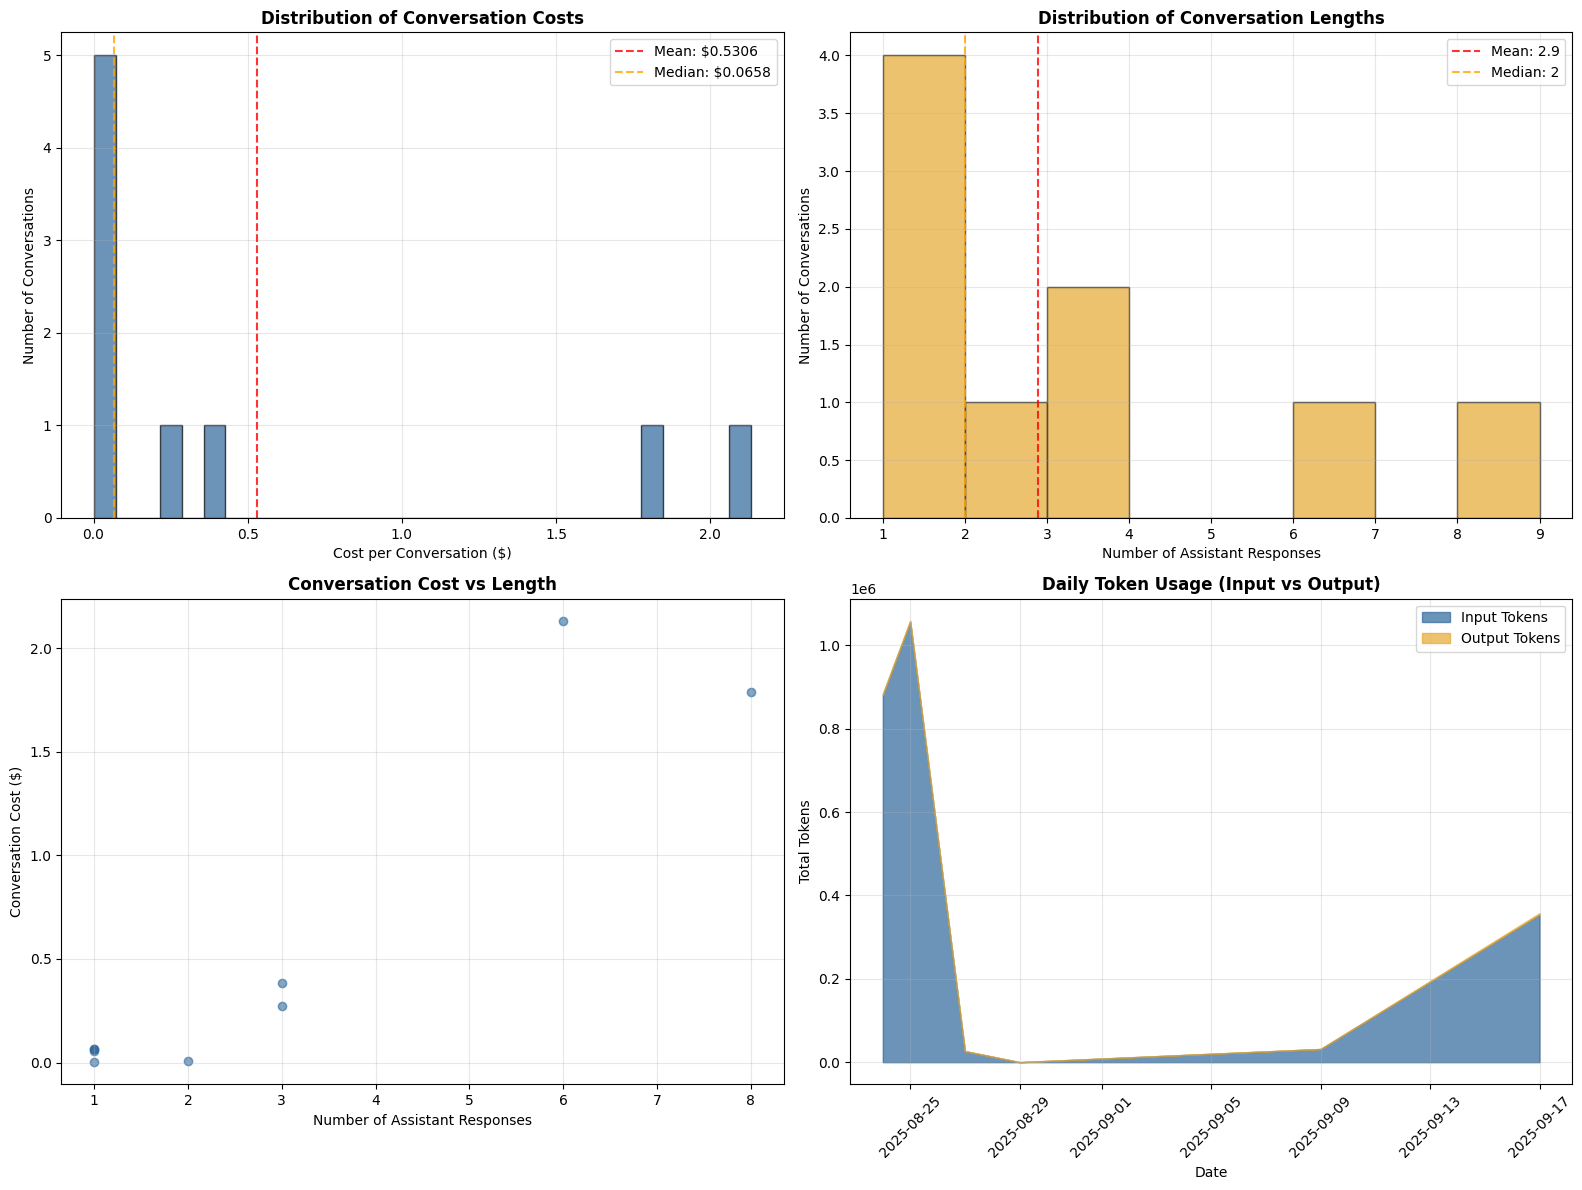


💰 DETAILED COST ESTIMATION:
----------------------------------------

Token breakdown:
  Input tokens: 2,351,047 @ $2/1M = $4.7021
  Output tokens: 9,156 @ $8/1M = $0.0732
  Total cost (30 days): $4.7753
  Daily average: $0.1592
  Estimated monthly cost: $4.7753

💳 COST BY TOP USERS:
   Angus Weich: $2.1323 ($2.1141 input + $0.0182 output)
   Robert Thompson: $1.7877 ($1.7631 input + $0.0246 output)
   Avinash Figueiredo: $0.7911 ($0.7617 input + $0.0294 output)
   Hamish Johnstone: $0.0642 ($0.0632 input + $0.0011 output)

📊 EFFICIENCY INSIGHTS:
Average input/output ratio: 256.8:1
Cost per conversation: $0.5306
Most expensive conversation: $2.1323
Cheapest conversation: $0.0011


In [20]:
# Add total token columns for easier analysis
token_df['total_tokens'] = token_df['input_tokens'] + token_df['output_tokens']
token_df['weighted_total_tokens'] = token_df['input_tokens'] + 4*token_df['output_tokens']

# Calculate totals
total_input_tokens = token_df['input_tokens'].sum()
total_output_tokens = token_df['output_tokens'].sum()
total_weighted_tokens = token_df['weighted_total_tokens'].sum()

print(f"\n📈 TOKEN USAGE STATISTICS (Last 30 days)")
print("=" * 50)

# Per-conversation statistics
print(f"Total conversations analyzed: {len(token_df)}")
print(f"Total input tokens: {total_input_tokens:,}")
print(f"Total output tokens: {total_output_tokens:,}")
print(f"Total combined tokens: {total_input_tokens + total_output_tokens:,}")
print(f"Input/Output ratio: {total_input_tokens/total_output_tokens:.1f}:1")

print(f"\nPer-conversation averages:")
print(f"Average input tokens per conversation: {token_df['input_tokens'].mean():.0f}")
print(f"Average output tokens per conversation: {token_df['output_tokens'].mean():.0f}")
print(f"Average total tokens per conversation: {token_df['total_tokens'].mean():.0f}")
print(f"Median total tokens per conversation: {token_df['total_tokens'].median():.0f}")
print(f"Token usage range: {token_df['total_tokens'].min():,} - {token_df['total_tokens'].max():,}")

# Per-response statistics  
print(f"\nPer-response averages:")
print(f"Average input tokens per assistant response: {(token_df['input_tokens']/token_df['assistant_responses']).mean():.0f}")
print(f"Average output tokens per assistant response: {(token_df['output_tokens']/token_df['assistant_responses']).mean():.0f}")

# Conversation length and cost analysis
print(f"\n💬 CONVERSATION LENGTH ANALYSIS:")
print(f"Average conversation length: {token_df['assistant_responses'].mean():.1f} assistant responses")
print(f"Median conversation length: {token_df['assistant_responses'].median():.0f} assistant responses")
print(f"Conversation length range: {token_df['assistant_responses'].min()} - {token_df['assistant_responses'].max()} responses")
print(f"Most common length: {token_df['assistant_responses'].mode().iloc[0]} responses")

# Calculate per-conversation costs for analysis
token_df['conversation_cost'] = (token_df['input_tokens'] / 1_000_000) * input_cost_per_million + (token_df['output_tokens'] / 1_000_000) * output_cost_per_million

print(f"\n💰 CONVERSATION COST ANALYSIS:")
print(f"Average cost per conversation: ${token_df['conversation_cost'].mean():.4f}")
print(f"Median cost per conversation: ${token_df['conversation_cost'].median():.4f}")
print(f"Cost range: ${token_df['conversation_cost'].min():.4f} - ${token_df['conversation_cost'].max():.4f}")
print(f"Standard deviation: ${token_df['conversation_cost'].std():.4f}")

# Cost percentiles
print(f"\nCost percentiles:")
print(f"  25th percentile: ${token_df['conversation_cost'].quantile(0.25):.4f}")
print(f"  50th percentile: ${token_df['conversation_cost'].quantile(0.50):.4f}")
print(f"  75th percentile: ${token_df['conversation_cost'].quantile(0.75):.4f}")
print(f"  95th percentile: ${token_df['conversation_cost'].quantile(0.95):.4f}")

# Top token consumers
print(f"\n🔥 HIGHEST TOKEN USAGE CONVERSATIONS:")
top_consumers = token_df.nlargest(5, 'total_tokens')[['conversation_id', 'user_id', 'input_tokens', 'output_tokens', 'total_tokens', 'assistant_responses']]
for _, conv in top_consumers.iterrows():
    print(f"   {conv['conversation_id'][:8]}... ({conv['user_id']}): {conv['input_tokens']:,} in + {conv['output_tokens']:,} out = {conv['total_tokens']:,} tokens ({conv['assistant_responses']} responses)")

# User-level analysis
user_usage = token_df.groupby('user_id').agg({
    'input_tokens': 'sum',
    'output_tokens': 'sum',
    'total_tokens': 'sum',
    'conversation_id': 'count'
}).sort_values('total_tokens', ascending=False)

print(f"\n👥 TOP TOKEN CONSUMERS BY USER:")
for user, data in user_usage.head(5).iterrows():
    print(f"   {user}: {data['input_tokens']:,} in + {data['output_tokens']:,} out = {data['total_tokens']:,} tokens ({data['conversation_id']} conversations)")

# Calculate conversation costs and lengths for visualization
token_df['conversation_cost'] = (token_df['input_tokens'] / 1_000_000) * input_cost_per_million + (token_df['output_tokens'] / 1_000_000) * output_cost_per_million

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Distribution of conversation costs
ax1.hist(token_df['conversation_cost'], bins=30, alpha=0.7, color='#2e679c', edgecolor='black')
ax1.set_title('Distribution of Conversation Costs', fontweight='bold')
ax1.set_xlabel('Cost per Conversation ($)')
ax1.set_ylabel('Number of Conversations')
ax1.grid(True, alpha=0.3)

# Add statistics to the cost distribution plot
cost_mean = token_df['conversation_cost'].mean()
cost_median = token_df['conversation_cost'].median()
ax1.axvline(cost_mean, color='red', linestyle='--', alpha=0.8, label=f'Mean: ${cost_mean:.4f}')
ax1.axvline(cost_median, color='orange', linestyle='--', alpha=0.8, label=f'Median: ${cost_median:.4f}')
ax1.legend()

# Distribution of conversation lengths (number of assistant responses as proxy)
ax2.hist(token_df['assistant_responses'], bins=range(1, max(token_df['assistant_responses'])+2), 
         alpha=0.7, color='#e6a832', edgecolor='black')
ax2.set_title('Distribution of Conversation Lengths', fontweight='bold')
ax2.set_xlabel('Number of Assistant Responses')
ax2.set_ylabel('Number of Conversations')
ax2.grid(True, alpha=0.3)

# Add statistics to the length distribution plot
length_mean = token_df['assistant_responses'].mean()
length_median = token_df['assistant_responses'].median()
ax2.axvline(length_mean, color='red', linestyle='--', alpha=0.8, label=f'Mean: {length_mean:.1f}')
ax2.axvline(length_median, color='orange', linestyle='--', alpha=0.8, label=f'Median: {length_median:.0f}')
ax2.legend()

# Cost vs Conversation Length scatter plot
ax3.scatter(token_df['assistant_responses'], token_df['conversation_cost'], alpha=0.6, color='#2e679c')
ax3.set_title('Conversation Cost vs Length', fontweight='bold')
ax3.set_xlabel('Number of Assistant Responses')
ax3.set_ylabel('Conversation Cost ($)')
ax3.grid(True, alpha=0.3)

# Daily token usage over time (input vs output)
token_df['date'] = token_df['last_updated'].dt.date
daily_input_tokens = token_df.groupby('date')['input_tokens'].sum()
daily_output_tokens = token_df.groupby('date')['output_tokens'].sum()

# Align the indices to handle any missing dates
all_dates = daily_input_tokens.index.union(daily_output_tokens.index)
daily_input_tokens = daily_input_tokens.reindex(all_dates, fill_value=0)
daily_output_tokens = daily_output_tokens.reindex(all_dates, fill_value=0)

ax4.fill_between(daily_input_tokens.index, daily_input_tokens.values, alpha=0.7, color='#2e679c', label='Input Tokens')
ax4.fill_between(daily_output_tokens.index, daily_input_tokens.values, 
                 daily_input_tokens.values + daily_output_tokens.values, alpha=0.7, color='#e6a832', label='Output Tokens')
ax4.set_title('Daily Token Usage (Input vs Output)', fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('Total Tokens')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Detailed cost estimation based on actual input/output pricing
print(f"\n💰 DETAILED COST ESTIMATION:")
print("-" * 40)


# Calculate costs
input_cost = (total_input_tokens / 1_000_000) * input_cost_per_million
output_cost = (total_output_tokens / 1_000_000) * output_cost_per_million
total_cost = input_cost + output_cost

print(f"\nToken breakdown:")
print(f"  Input tokens: {total_input_tokens:,} @ ${input_cost_per_million}/1M = ${input_cost:.4f}")
print(f"  Output tokens: {total_output_tokens:,} @ ${output_cost_per_million}/1M = ${output_cost:.4f}")
print(f"  Total cost (30 days): ${total_cost:.4f}")
print(f"  Daily average: ${total_cost/30:.4f}")
print(f"  Estimated monthly cost: ${total_cost:.4f}")

# Cost breakdown by user
print(f"\n💳 COST BY TOP USERS:")
for user, data in user_usage.head(5).iterrows():
    user_input_cost = (data['input_tokens'] / 1_000_000) * input_cost_per_million
    user_output_cost = (data['output_tokens'] / 1_000_000) * output_cost_per_million
    user_total_cost = user_input_cost + user_output_cost
    print(f"   {user}: ${user_total_cost:.4f} (${user_input_cost:.4f} input + ${user_output_cost:.4f} output)")

# Additional insights
print(f"\n📊 EFFICIENCY INSIGHTS:")
print(f"Average input/output ratio: {total_input_tokens/total_output_tokens:.1f}:1")
print(f"Cost per conversation: ${total_cost/len(token_df):.4f}")
print(f"Most expensive conversation: ${(top_consumers.iloc[0]['input_tokens']/1_000_000)*input_cost_per_million + (top_consumers.iloc[0]['output_tokens']/1_000_000)*output_cost_per_million:.4f}")
print(f"Cheapest conversation: ${(token_df['input_tokens'].min()/1_000_000)*input_cost_per_million + (token_df['output_tokens'].min()/1_000_000)*output_cost_per_million:.4f}")